# Algorithmic Trading Model for Naive Momentum Strategy with Grid Search Using Python
### David Lowe
### December 9, 2020

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template. We will test trading models with the naive momentum strategy.

INTRODUCTION: This algorithmic trading model examines a simplistic naive momentum strategy in comparison to a buy-and-hold approach. The plan goes long (buys) on the stock when the daily closing price improves from the previous day for a pre-defined consecutive number of days. Conversely, we will exit the position when the daily price declines for the same successive number of days. Furthermore, we will use the trading volumes to confirm the buy and sell signals by comparing them to the 10-day moving average.

ANALYSIS: From this iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2019, and December 4, 2020. The best trading model out of the 18 variations produced a profit of 80.93 dollars per share. The buy-and-hold approach yielded a gain of 83.88 dollars per share.

CONCLUSION: For the stock of AAPL during the modeling time frame, the trading strategy did not produce a better return than the buy-and-hold approach. We should consider modeling this stock further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#
# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Retrieve the CPU information
# ncpu = !nproc
# print("The number of available CPUs is:", ncpu[0])

### 1.a) Load libraries and modules

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv
# import pandas_datareader.data as pdr

# Begin the timer for the script processing
startTimeScript = datetime.now()

### 1.b) Set up the controlling parameters and functions¶

In [6]:
# Specify the key modeling parameters below
STOCK_SYMBOL = 'AAPL'
INITIAL_CAPITAL = 0

# Specify the moving average parameters for the trading strategy
CONSEC_UP_DAYS = 3
CONSEC_DN_DAYS = 3
VOL_MA_DAYS = 10

MAX_UP_DAYS = 4
MIN_UP_DAYS = 2
MAX_DN_DAYS = 4
MIN_DN_DAYS = 2
MAX_VOL_MA = 15
MIN_VOL_MA = 10
DAY_INCREMENT = 1
VOL_INCREMENT = 5

MODEL_START_DATE = date(2019, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

MODEL_END_DATE = datetime.now().date()
# model_end_date = date(2020, 11, 20)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = model_start_date
data_start_date = MODEL_START_DATE - timedelta(days=int(VOL_MA_DAYS * 1.5)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

Starting date for the model: 2019-01-01
Ending date for the model: 2020-12-04
First date of data we need for modeling: 2018-12-17
Last date of data we need for modeling: 2020-12-04


In [7]:
# Specify the script running parameters below
# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# Configure the plotting style
plt.style.use('seaborn')

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_signals = False
verbose_models = False
verbose_graphs = True
verbose_portfolios = False
verbose_transactions = True
verbose_positions = True

In [8]:
# Set up the parent directory location for loading the dotenv files

# # Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up access to the dotenv file on local PC
env_path = "/Users/david/PycharmProjects/"
dotenv_path = env_path + "python_script.env"
load_dotenv(dotenv_path=dotenv_path)

True

## Task 2 - Acquire and Pre-Process Data

In [9]:
# Set up the data service provider and data acquisition parameters
data_service = 'Quandl'

# Check and see whether the API key is available
api_key = os.environ.get('QUANDL_API')
if api_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

start_date_string = data_start_date.strftime('%Y-%m-%d')
end_date_string = data_end_date.strftime('%Y-%m-%d')
api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, STOCK_SYMBOL, api_key)
response = requests.get(api_url)
resp_dict = json.loads(response.text)
stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
print(len(stock_rawdata), 'data points retrieved from the API call.')

497 data points retrieved from the API call.


In [10]:
stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_rawdata.set_index('date', inplace=True)
stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
stock_pricing = stock_rawdata.sort_index(ascending=True)
print(stock_pricing.head())
print()
print(stock_pricing.tail())

           ticker        date    open    high     low   close       volume  dividend  closeunadj lastupdated
date                                                                                                        
2018-12-17   AAPL  2018-12-17  41.362  42.087  40.682  40.985  177151688.0       0.0      163.94  2020-08-31
2018-12-18   AAPL  2018-12-18  41.345  41.883  41.097  41.517  135366072.0       0.0      166.07  2020-08-31
2018-12-19   AAPL  2018-12-19  41.500  41.862  39.773  40.222  196189188.0       0.0      160.89  2020-08-31
2018-12-20   AAPL  2018-12-20  40.100  40.528  38.825  39.208  259091840.0       0.0      156.83  2020-08-31
2018-12-21   AAPL  2018-12-21  39.215  39.540  37.407  37.682  382977536.0       0.0      150.73  2020-08-31

           ticker        date    open     high     low   close       volume  dividend  closeunadj lastupdated
date                                                                                                         
2020-11-30   AAP

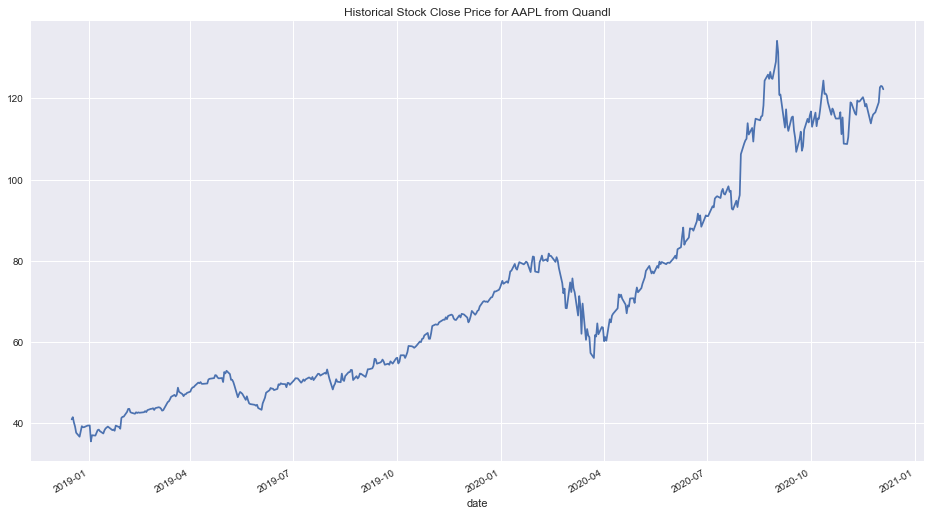

In [11]:
# Set up the standard column name for modeling
# Column names may be data-provider specific!
MODEL_TEMPLATE = stock_pricing.loc[:, ['open','close','volume']]
MODEL_TEMPLATE.rename(columns={'open': 'open_price', 'close': 'close_price', 'volume': 'trading_volume'}, inplace=True)
plot_title = 'Historical Stock Close Price for ' + STOCK_SYMBOL + ' from ' + data_service
MODEL_TEMPLATE['close_price'].plot(figsize=(16,9), title=plot_title)
plt.show()

## Task 3 - Implement and Train Models

In [12]:
# Define the function that will generate the indicators and trading signals
def populate_signals(up_days=CONSEC_UP_DAYS, down_days=CONSEC_DN_DAYS, vol_ma=VOL_MA_DAYS):
    trade_model = MODEL_TEMPLATE.copy()
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(vol_ma).mean()
    trade_model['momentum_streak'] = 0
    trade_model['trade_signal'] = 0
    trade_model['entry_exit'] = 0
    consecutive_days = 0
    prior_signal = 0
    prior_price = 0.0
    currently_own = False
    init = True

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]

    for k in range(len(trade_model)):
        current_signal = 0
        price = trade_model.at[trade_model.index[k], 'close_price']
        trade_volume = trade_model.at[trade_model.index[k], 'trading_volume']
        average_volume = trade_model.at[trade_model.index[k], 'volume_ma']
        trade_model.at[trade_model.index[k], 'entry_exit'] = prior_signal
        if init:
            init = False
        else:
            if price > prior_price:
                if consecutive_days < 0: consecutive_days = 0
                consecutive_days += 1
            elif price < prior_price:
                if consecutive_days > 0: consecutive_days = 0
                consecutive_days -= 1
            trade_model.at[trade_model.index[k], 'momentum_streak'] = consecutive_days
            if (consecutive_days == up_days) and (trade_volume > average_volume) and (not currently_own):
                current_signal = 1  # trade_signal = 1 means we should buy
                currently_own = True
                consecutive_days = 0
            elif (consecutive_days == -down_days) and (trade_volume > average_volume) and currently_own:
                current_signal = -1  # trade_signal = -1 means we should sell
                currently_own = False
                consecutive_days = 0
        trade_model.at[trade_model.index[k], 'trade_signal'] = current_signal
        prior_signal = current_signal
        prior_price = price

    # Exiting the position on the last day of modeling period
    if currently_own:
        trade_model.at[trade_model.index[-1], 'entry_exit'] = -1
    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [13]:
# Build the collection of trading models by iterating through the parameters
trading_model_collection = {}
serial_no = 0
for model_up in range(MIN_UP_DAYS, MAX_UP_DAYS+1, DAY_INCREMENT):
    for model_dn in range(MIN_DN_DAYS, MAX_DN_DAYS+1, DAY_INCREMENT):
        for model_vol in range(MIN_VOL_MA, MAX_VOL_MA+1, VOL_INCREMENT):
            serial_no += 1
            model_tag = 'Model_' + str(serial_no).zfill(3) + '_UP_' + str(model_up).zfill(2) + '_DN_' + str(model_dn).zfill(2) + '_VOL_' + str(model_vol).zfill(2)
            if verbose_signals: print('Processing model:', model_tag)
            trading_model = populate_signals(model_up, model_dn, model_vol)
            trading_model_collection[model_tag] = trading_model.copy()
print(len(trading_model_collection), 'trading models generated!')

18 trading models generated!


In [14]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[(trade_model['trade_signal'] != 0) | (trade_model['entry_exit'] != 0)])

In [15]:
if verbose_models:
    for model_name in trading_model_collection:
        print('List the signal changes and entry/exit points for model:', model_name)
        list_model_entry_exit(trading_model_collection[model_name])
        print()

In [16]:
def draw_model_graph(trade_model, mdl_name=STOCK_SYMBOL):
    graph_data = trade_model.copy()
    title_string = 'Naive Momentum Trading Model for ' + mdl_name
    fig = plt.figure(figsize=(16,9))
    ylabel = STOCK_SYMBOL + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend(loc='upper left')
    plt.show()

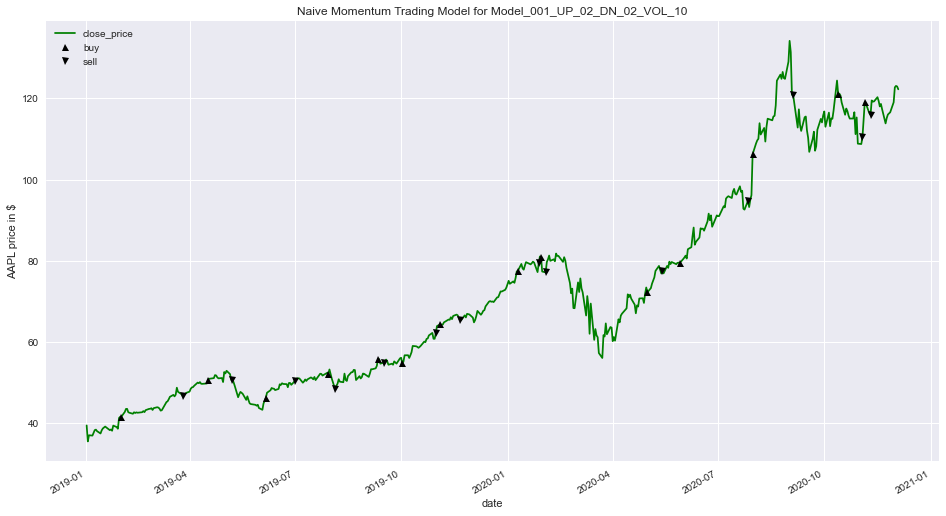

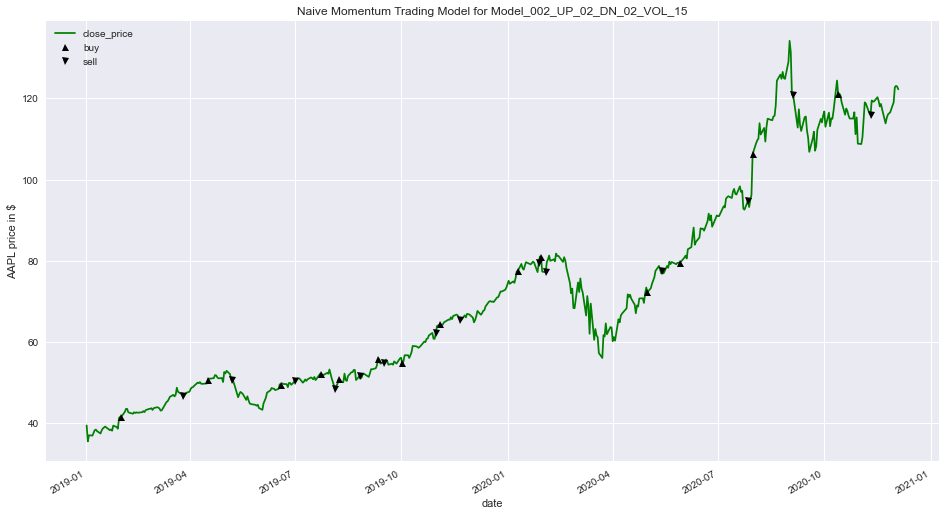

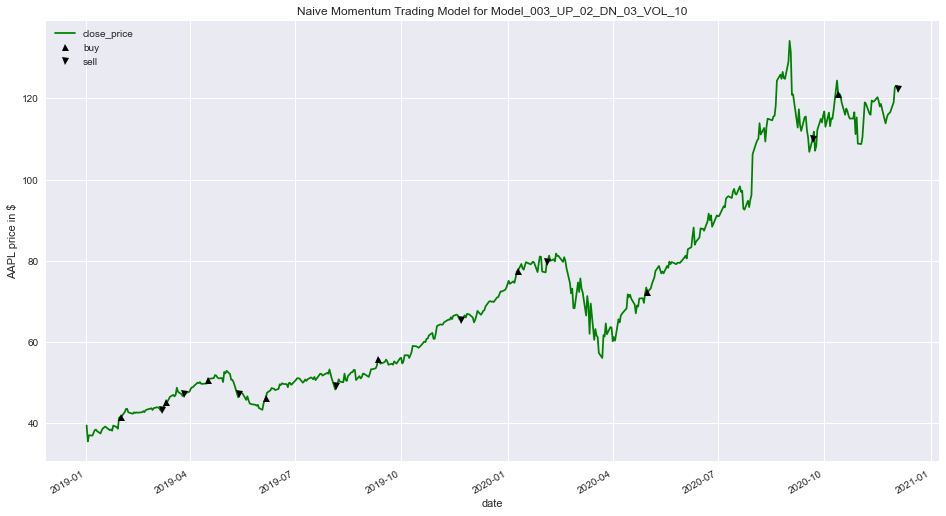

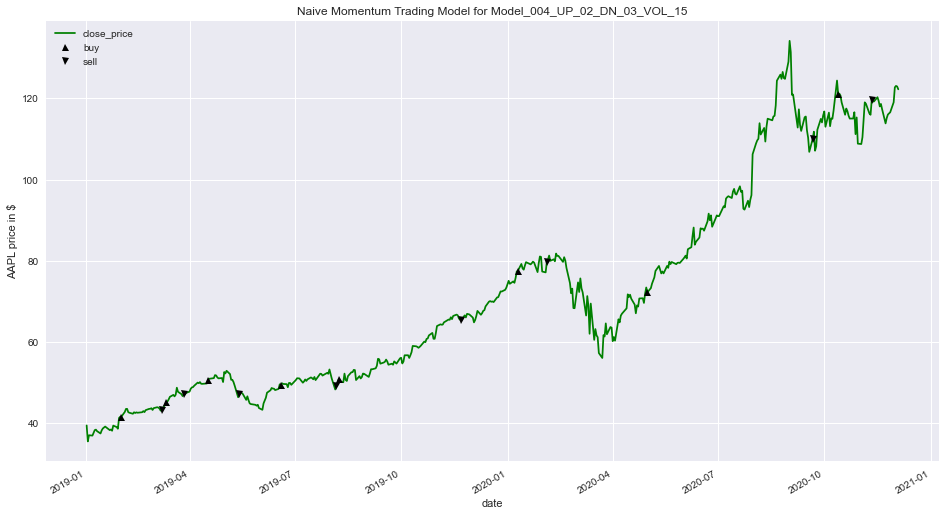

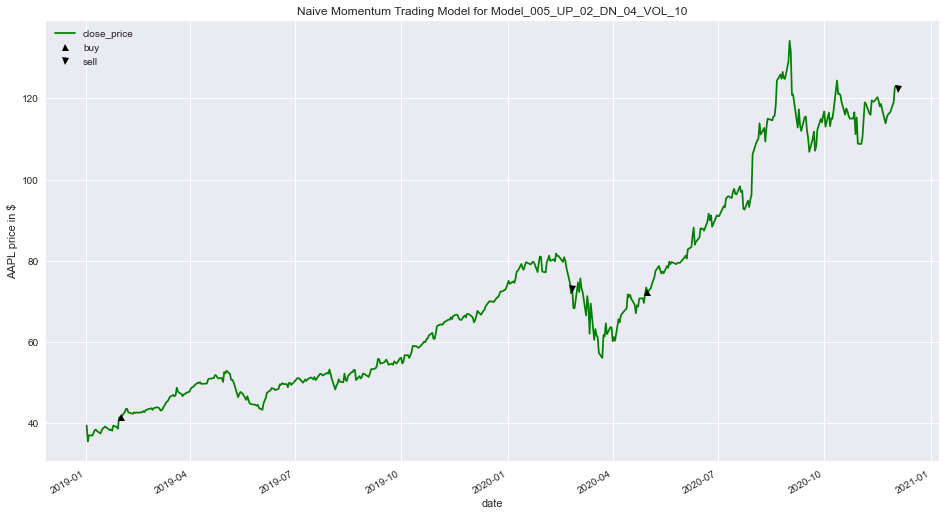

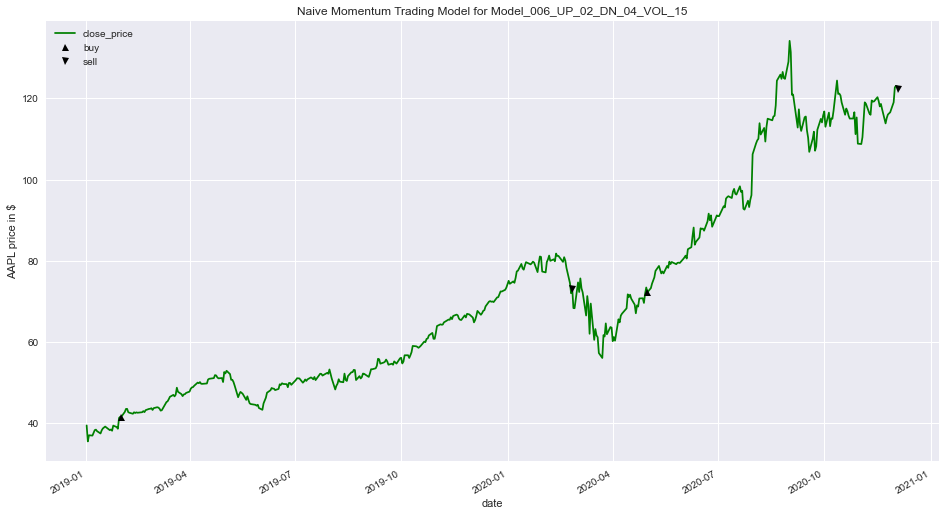

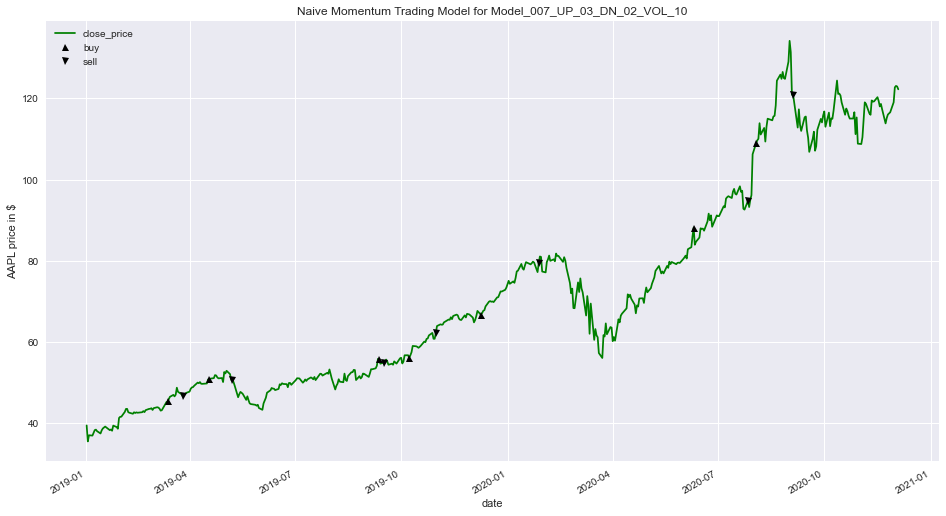

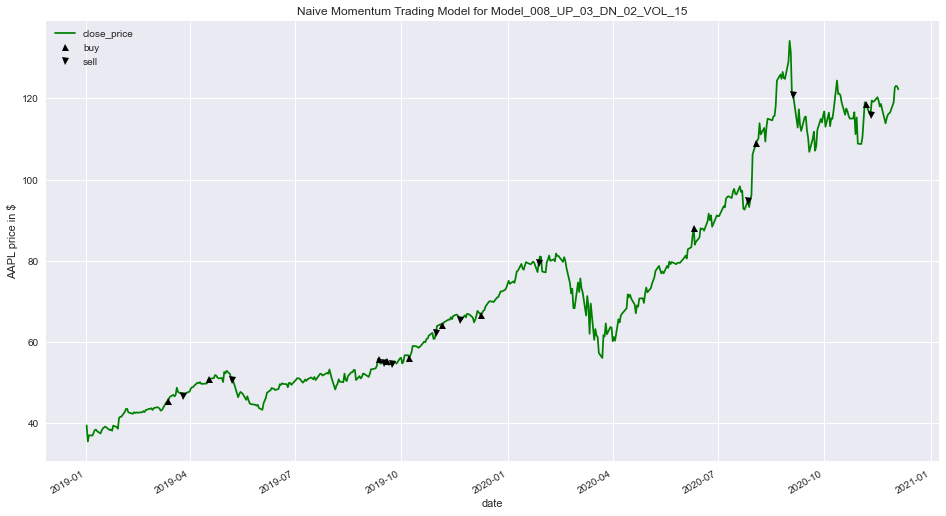

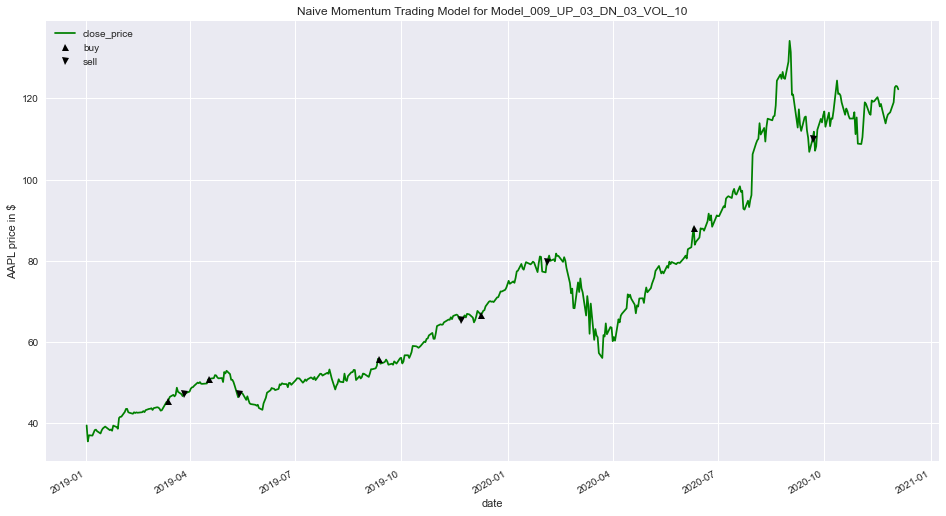

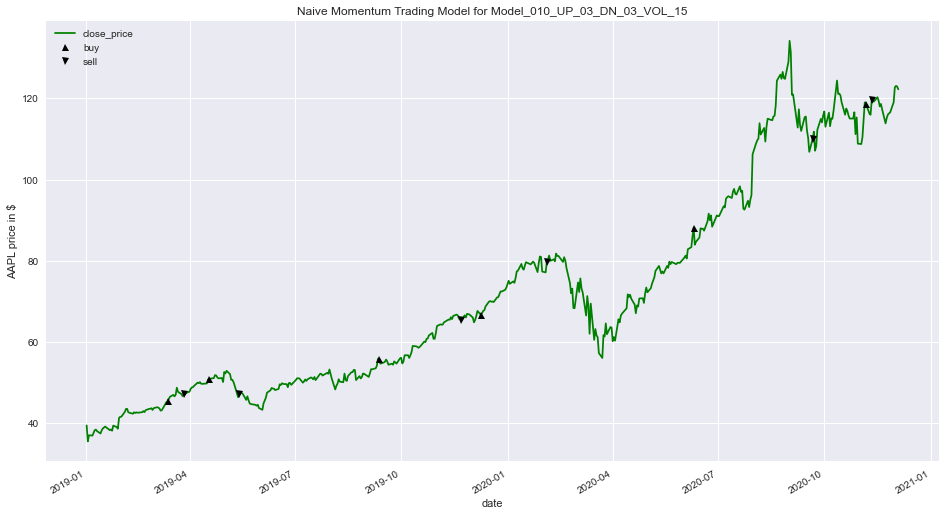

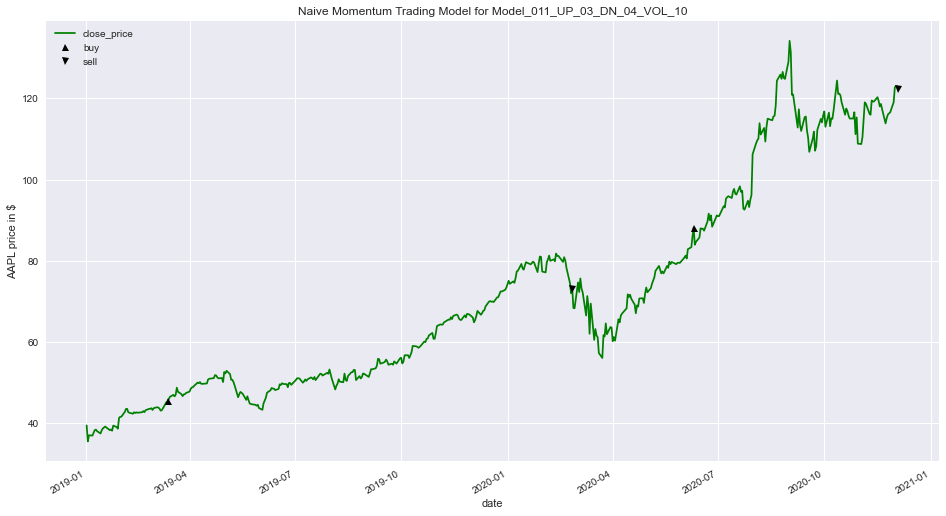

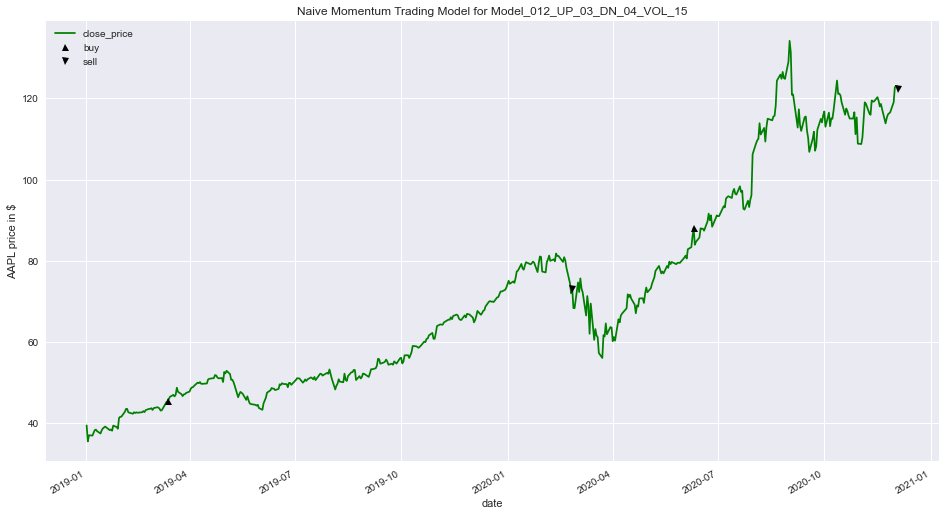

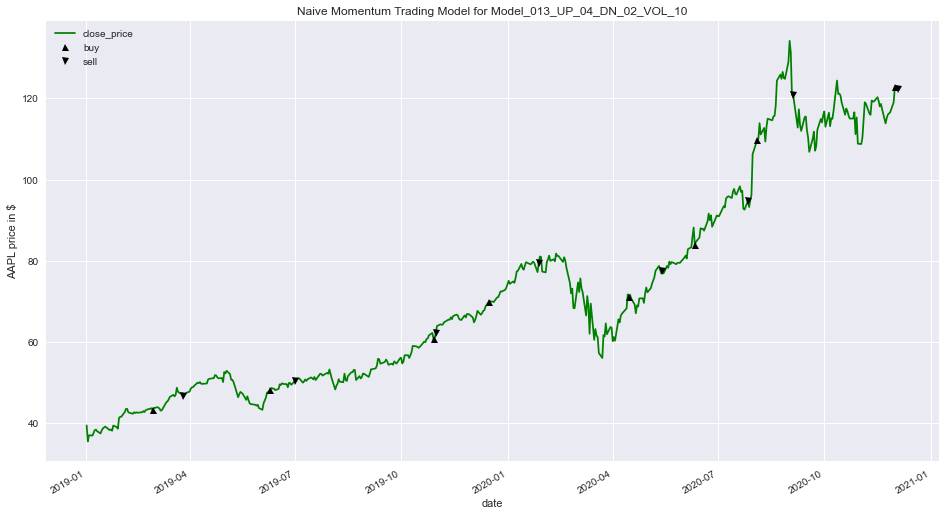

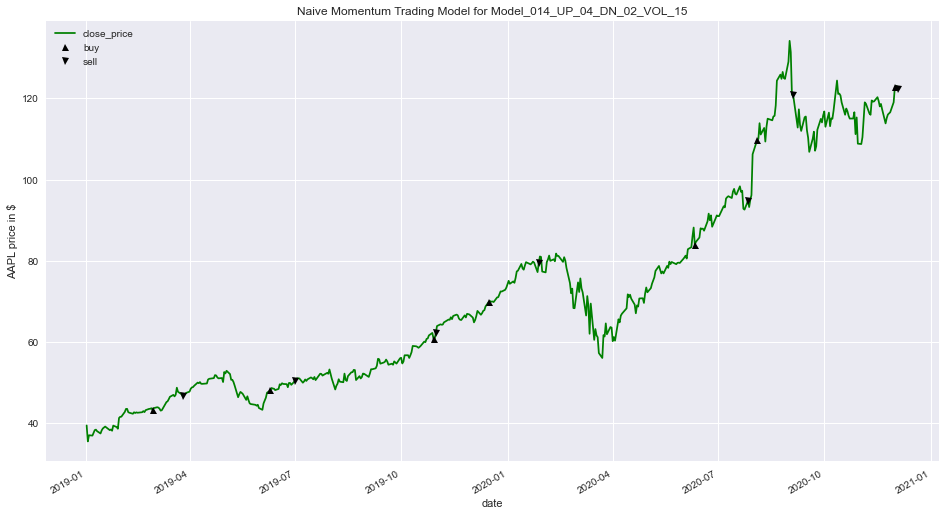

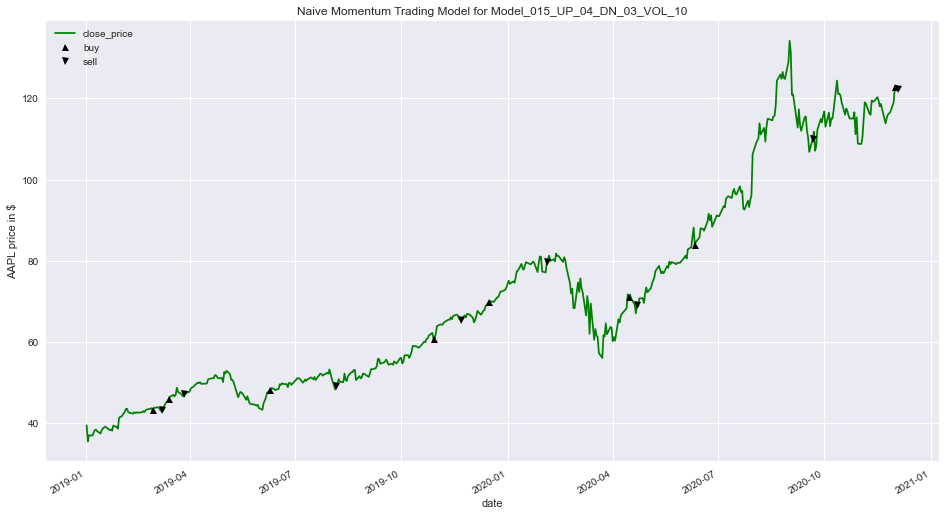

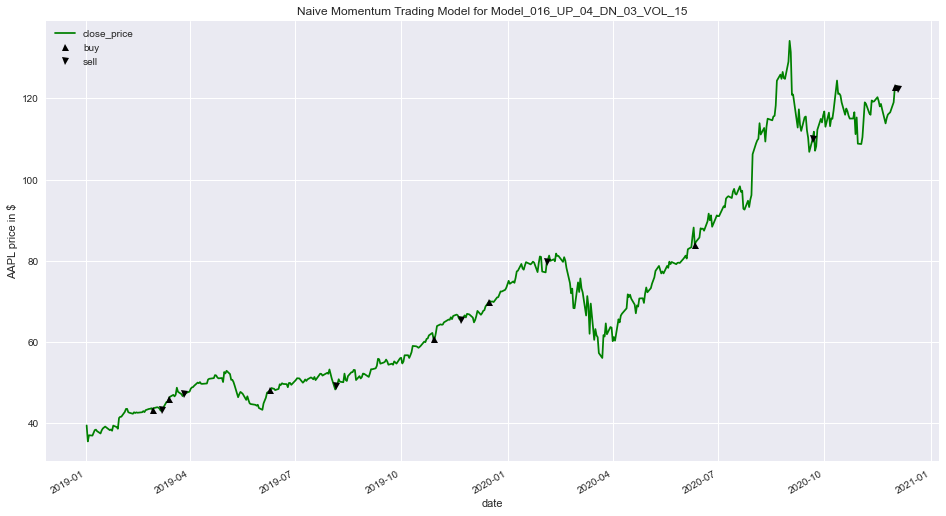

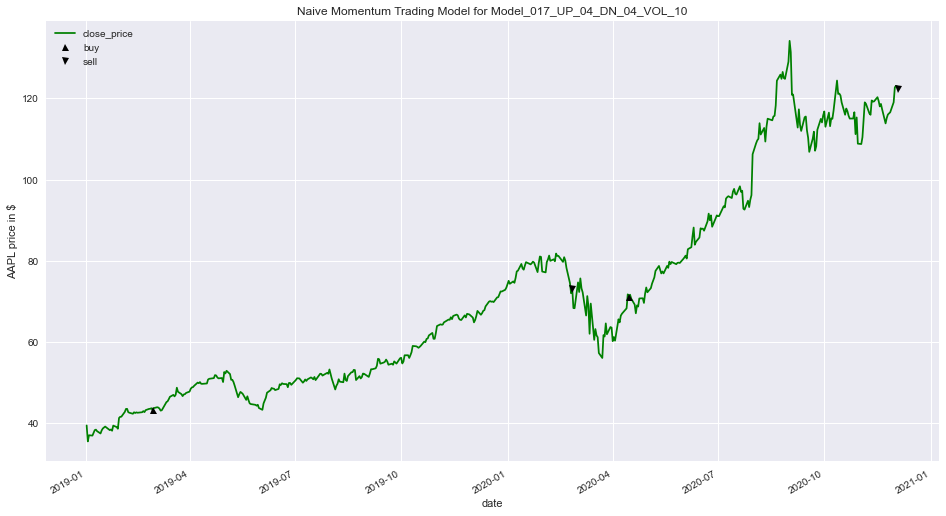

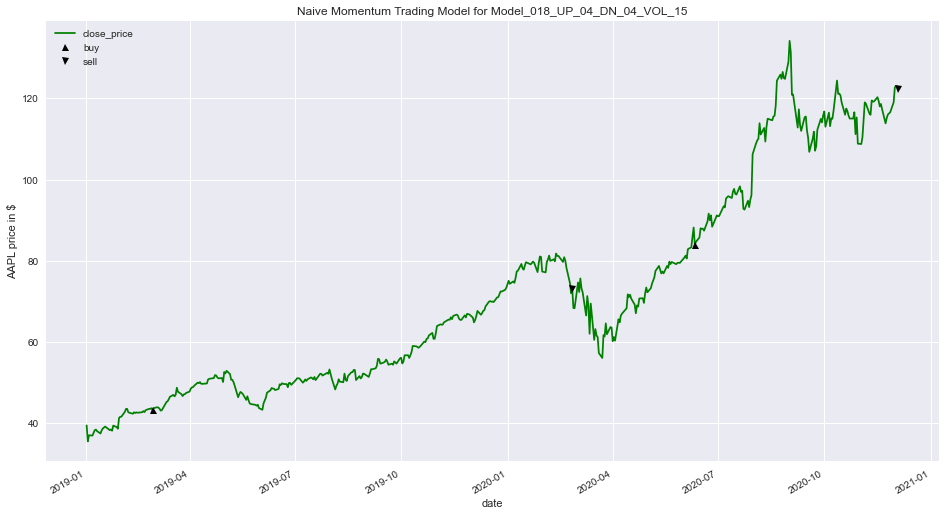

In [17]:
if verbose_graphs:
    for model_name in trading_model_collection:
        draw_model_graph(trading_model_collection[model_name], model_name)

## Task 4 - Back-test Models

In [18]:
def generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = INITIAL_CAPITAL
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = INITIAL_CAPITAL
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - INITIAL_CAPITAL
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trade_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose_portfolios: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif (trade_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose_portfolios: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trade_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [19]:
def calculate_positions_and_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action'] != 0]
    if verbose_transactions: print(trade_transactions)
    if verbose_transactions:
        if trade_transactions.iloc[-1]['trade_action'] == 1:
            print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1].date(), '\n')
        else:
            print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1].date(), '\n')
    return trade_positions

In [20]:
# Convert trading models into positions and calculate profit and loss
# Initialize a dictionary for tracking positions for all models
model_positions_colletion={}
# Initialize a dataframe for storing the model's profit and loss
model_performance_summary = pd.DataFrame(columns=['Model_name','Return_value','Return_percentage'])

for model_name in trading_model_collection:
    if verbose_portfolios: print('Processing positions for model:', model_name)
    model_positions_colletion[model_name] = calculate_positions_and_performance(trading_model_collection[model_name])
print(len(model_positions_colletion), 'sets of model positions generated.')

           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accumu_return
date                                                                                                                            
2019-02-01            1          1      41.74                0         0      -41.74          41.63          -0.11         -0.11
2019-03-26           -1          0          0           47.916     6.176       6.176              0          6.176         6.176
2019-04-17            1          1     49.885                0         0     -43.709         50.782          7.073         7.073
2019-05-08           -1          0          0           50.475      0.59       6.766              0          6.766         6.766
2019-06-06            1          1      45.77                0         0     -39.004         46.305          7.301         7.301
2019-07-01           -1          0          0           50.792     5.022      11.788             

In [21]:
for model_name in model_positions_colletion:
    if verbose_positions: print('Processing positions for model:', model_name)
    if verbose_positions: print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model_positions_colletion[model_name].accumu_return[-1]))
    if INITIAL_CAPITAL != 0:
        return_percentage = model_positions_colletion[model_name].accumu_return[-1] / INITIAL_CAPITAL * 100
        if verbose_positions: print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
    else:
        return_percentage = None
    if verbose_positions: print()
    model_performance_summary = model_performance_summary.append({'Model_name': model_name, 'Return_value': model_positions_colletion[model_name].accumu_return[-1], 'Return_percentage': return_percentage}, ignore_index=True)
    model_performance_summary.sort_values(by=['Return_value'], inplace=True, ascending=False)

print(len(model_performance_summary), 'profit/loss summaries generated.\n')
print('The top ten model\'s performance summary:')
print(model_performance_summary.head(10))

Processing positions for model: Model_001_UP_02_DN_02_VOL_10
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $30.72

Processing positions for model: Model_002_UP_02_DN_02_VOL_15
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $36.55

Processing positions for model: Model_003_UP_02_DN_03_VOL_10
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $45.67

Processing positions for model: Model_004_UP_02_DN_03_VOL_15
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $40.58

Processing positions for model: Model_005_UP_02_DN_04_VOL_10
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $80.93

Processing positions for model: Model_006_UP_02_DN_04_VOL_15
Accumulated profit/loss for one share of stock with initial capital o

## Task 5 - Evaluate Strategy Performance

In [22]:
# Calculate the stock's performance for a buy-and-hold model
top_model_name = model_performance_summary.loc[0]['Model_name']
top_trading_model = trading_model_collection[top_model_name]
print('The entry point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[0]['open_price'], top_trading_model.index[0].date()))
print('The exit point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[-1]['open_price'], top_trading_model.index[-1].date()))
print('The performance of the top trading model is: $%.2f' %(model_performance_summary.iloc[0]['Return_value']))
print('The performance of the long-only model from day one is: $%.2f' %(top_trading_model.iloc[-1]['open_price'] - top_trading_model.iloc[0]['open_price']))

The entry point for the buy-and-hold model: $38.72 on 2019-01-02
The exit point for the buy-and-hold model: $122.60 on 2020-12-04
The performance of the top trading model is: $80.93
The performance of the long-only model from day one is: $83.88


In [23]:
top_model_positions = model_positions_colletion[top_model_name]
print(top_model_positions[top_model_positions['trade_action'] != 0])

           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accumu_return
date                                                                                                                            
2019-02-01            1          1      41.74                0         0      -41.74          41.63          -0.11         -0.11
2020-02-26           -1          0          0           71.632    29.892      29.892              0         29.892        29.892
2020-05-01            1          1     71.563                0         0     -41.671         72.267         30.596        30.596
2020-12-04           -1          0          0            122.6    51.037      80.929              0         80.929        80.929


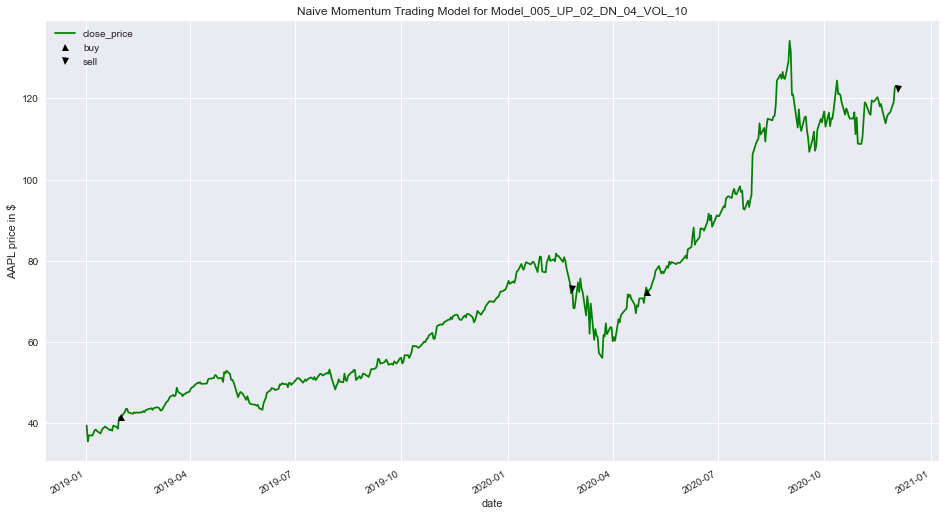

In [24]:
draw_model_graph(trading_model_collection[top_model_name], top_model_name)

In [25]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:16.886804
